In [1]:
###################################################################################################
#
# Copyright (C) 2023 Maxim Integrated Products, Inc. All Rights Reserved.
#
# Maxim Integrated Products, Inc. Default Copyright Notice:
# https://www.maximintegrated.com/en/aboutus/legal/copyrights.html
#
###################################################################################################

import os
import sys

import numpy as np
import random
import torch
from torch.utils import data
from torchmetrics.detection.mean_ap import MeanAveragePrecision

import matplotlib.patches as patches
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '../models/'))

from collections import OrderedDict

import ai8x
from datasets import pascalvoc
from utils import parse_obj_detection_yaml

ai87_fpndetector = __import__("ai87-fpndetector")

import parse_qat_yaml

import torch.nn as nn

from utils import object_detection_utils

from distiller import apputils

%matplotlib inline

In [2]:
device = "cpu"
data_path = '/data_ssd/'

class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

simulate = True
args = Args(act_mode_8bit=simulate)


_, test_set = \
    pascalvoc.pascal_voc_2007_2012_256_320_aug_get_dataset((data_path, args), load_train=False, load_test=True)

Test dataset length: 4952



In [3]:
train_batch_size = 64
test_dataloader = data.DataLoader(test_set, batch_size=train_batch_size, collate_fn=object_detection_utils.collate_fn, shuffle=False)

In [4]:
num_classes = len(test_set.voc_labels) + 1

qat_yaml_file_used_in_training = '../policies/qat_policy_pascalvoc.yaml'
qat_policy = parse_qat_yaml.parse(qat_yaml_file_used_in_training)

checkpoint_path = '../../ai8x-synthesis/trained/ai87-pascalvoc-fpndetector-qat8-q.pth.tar'

ai8x.set_device(device=85, simulate=simulate, round_avg=False)

model = ai87_fpndetector.FeaturePyramidNetworkDetector(num_classes=num_classes, device=device)

# Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
ai8x.fuse_bn_layers(model)

# Switch model from unquantized to quantized for QAT
ai8x.initiate_qat(model, qat_policy)

model = apputils.load_lean_checkpoint(model, checkpoint_path, model_device=device)
ai8x.update_model(model)

model = model.to(device)

{'start_epoch': 250, 'weight_bits': 8}
Configuring device: MAX78000, simulate=True.


In [5]:
num_weights = 0
num_bias = 0

weights_flattened_tensor = torch.empty(size = (1, 1), device=device)

for name, param in model.named_parameters():
    if param.requires_grad:
        if name.endswith('weight'):
            num_weights += np.prod(param.size())
            
            weights_flattened_tensor = torch.cat((weights_flattened_tensor, torch.reshape(torch.flatten(param), (-1, 1))), 0)
            
        elif name.endswith('bias'):
            num_bias += np.prod(param.size())

print(f'Number of Model Weights: {num_weights}')
print(f'Number of Model Bias: {num_bias}\n')

Number of Model Weights: 2177088
Number of Model Bias: 3414



In [6]:
obj_detection_params_yaml_file = '../parameters/obj_detection_params_pascalvoc.yaml'
obj_detection_params = parse_obj_detection_yaml.parse(obj_detection_params_yaml_file)

min_score = obj_detection_params['nms']['min_score']
max_overlap = obj_detection_params['nms']['max_overlap']
top_k = obj_detection_params['nms']['top_k']

{'multi_box_loss': {'alpha': 2, 'neg_pos_ratio': 3}, 'nms': {'min_score': 0.3, 'max_overlap': 0.3, 'top_k': 50}}


### Sample model outputs

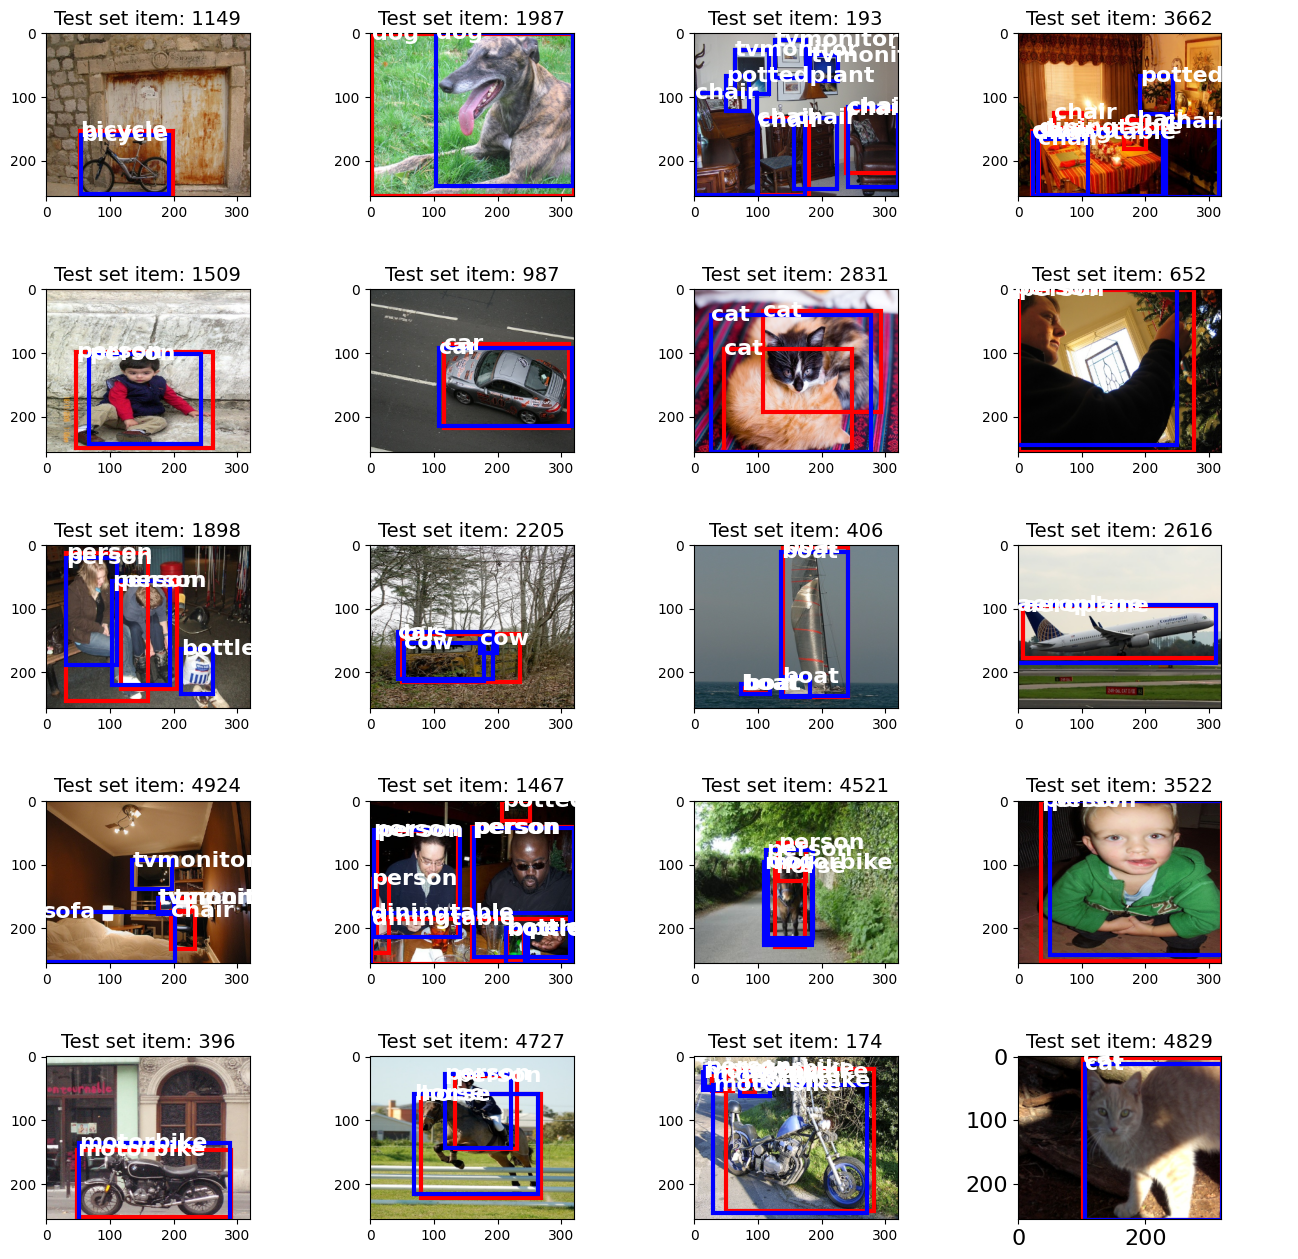

In [7]:
ncols = 4
nrows = 5

fig, axes = plt.subplots(nrows, ncols, figsize=(13, 13))
plt.tick_params(labelsize=16)

model.eval()

random.seed(22)
random_test_idxs = random.sample(list(range(len(test_set))), ncols * nrows)

for j in range(nrows):
    for i in range(ncols):

        img_idx = random_test_idxs[i + j * ncols]

        img, (boxes, lbls) = test_set[img_idx]
        img = img.to(device)

        img_model = img.unsqueeze(0)
        locs, scores = model(img_model)

        locs = locs / 128.
        scores = scores / 2.**14
        
        all_images_boxes, all_images_labels, all_images_scores = \
            model.detect_objects(locs, scores, 0.2, max_overlap, top_k)
        
        img_to_plot = img.cpu().detach().numpy()
        img_to_plot = (img_to_plot + 128).astype(np.uint8)
        img_to_plot = img_to_plot.transpose([1, 2, 0])
        
        axes[j, i].imshow(img_to_plot)

        subplot_title=("Test set item: " + str(img_idx))
        axes[j, i].set_title(subplot_title, fontsize = 14)

        # Truth boxes & labels
        boxes_resized = [[box[0] * img_to_plot.shape[1], \
                          box[1] * img_to_plot.shape[0], \
                          box[2] * img_to_plot.shape[1], \
                          box[3] * img_to_plot.shape[0]] for box in boxes]

        for b in range(len(boxes_resized)):
            bb = boxes_resized[b]
            rect = patches.Rectangle((bb[0], bb[1]), bb[2] - bb[0], bb[3] - bb[1], linewidth=3,
                                    edgecolor='r', facecolor="none")

            lbl_string = test_set.voc_id_to_label_map[lbls[b].cpu().detach().item()]
            axes[j, i].text(bb[0], bb[1], lbl_string, verticalalignment='center', color='white', fontsize=16, weight='bold')

            axes[j, i].add_patch(rect)

        # Predicted boxes & labels
        boxes_resized = [[box[0] * img_to_plot.shape[1], \
                          box[1] * img_to_plot.shape[0], \
                          box[2] * img_to_plot.shape[1], \
                          box[3] * img_to_plot.shape[0]] for box in all_images_boxes[0].detach().cpu().numpy()]

        detected_labels = all_images_labels[0]

        for b in range(len(boxes_resized)):

            if(detected_labels[b] != 0):
                bb = boxes_resized[b]
                rect = patches.Rectangle((bb[0], bb[1]), bb[2] - bb[0], bb[3] - bb[1], linewidth=3,
                                         edgecolor='b', facecolor="none")


                lbl_string = test_set.voc_id_to_label_map[detected_labels[b].cpu().detach().item()]
                axes[j, i].text(bb[0], (bb[1]), lbl_string, verticalalignment='center', color='white', fontsize=16, weight='bold')

                axes[j, i].add_patch(rect)

fig.tight_layout()
plt.show()



### Sample mAP Calculation using Torch Metrics

In [8]:
map_calculator = MeanAveragePrecision(box_format='xyxy', iou_type='bbox', class_metrics=True, iou_thresholds=[0.5])

model.eval()
with torch.no_grad():
    for idx, (image, target) in enumerate(test_dataloader):
        image = image.to(device)

        # Prepare truths
        boxes_list = [elem[0] for elem in target]
        labels_list = [elem[1] - 1 for elem in target]
        
        diffs_list = []
        for label_objects in labels_list:
            diffs_list.append(torch.zeros_like(label_objects))

        boxes_list = [boxes.to(device) for boxes in boxes_list]
        labels_list = [labels.to(device) for labels in labels_list]
        diffs_list = [diffs.to(device) for diffs in diffs_list]
        
        boxes = torch.cat(boxes_list)
        labels = torch.cat(labels_list)

        gt = [dict(boxes=boxes, labels=labels)]

        # Prepare predictions
        locs, scores = model(image)
        locs = locs / 128.
        scores = scores / 2.**14

        all_images_boxes, all_images_labels, all_images_scores = model.detect_objects(locs, scores, min_score, max_overlap, top_k)

        # Filter images with only background box

        filtered_images_boxes_labels_scores = \
            list(filter(lambda elem: not (len(elem[1]) == 1 and elem[1][0] == 0), \
                        zip(all_images_boxes, all_images_labels, all_images_scores)))

        filtered_all_images_boxes = [elem[0] for elem in filtered_images_boxes_labels_scores]

        # Adjust index as mAP calculator uses 0-indeed class labels
        filtered_all_images_labels = [elem[1] - 1 for elem in filtered_images_boxes_labels_scores]
        filtered_all_images_scores = [elem[2] for elem in filtered_images_boxes_labels_scores]

        pred_boxes = torch.cat(filtered_all_images_boxes)
        pred_scores = torch.cat(filtered_all_images_scores)
        pred_labels = torch.cat(filtered_all_images_labels)

        preds = [dict(boxes=pred_boxes, scores=pred_scores, labels=pred_labels)]

        map_calculator.update(preds=preds, target=gt)

mAPs = {"val_" + k: v for k, v in map_calculator.compute().items()}

In [9]:
print(f'mAP(%):           {100 * mAPs["val_map"]:.2f}')
print(f'mAP 50(%):        {100 * mAPs["val_map_50"]:.2f}')
print(f'mAP 75(%):        {100 * mAPs["val_map_75"]:.2f}')
print(f'mAP Small Obj(%): {100 * mAPs["val_map_small"]:.2f}')

mAP(%):           48.68
mAP 50(%):        48.68
mAP 75(%):        -100.00
mAP Small Obj(%): 48.68


In [10]:
from pprint import pprint
pprint(map_calculator.compute())

{'map': tensor(0.4868),
 'map_50': tensor(0.4868),
 'map_75': tensor(-1),
 'map_large': tensor(-1.),
 'map_medium': tensor(-1.),
 'map_per_class': tensor([0.5988, 0.6053, 0.3573, 0.3073, 0.0742, 0.5990, 0.5789, 0.6662, 0.2419,
        0.4416, 0.5108, 0.5925, 0.6664, 0.6223, 0.5691, 0.1830, 0.4246, 0.5506,
        0.6834, 0.4620]),
 'map_small': tensor(0.4868),
 'mar_1': tensor(0.1514),
 'mar_10': tensor(0.5023),
 'mar_100': tensor(0.5352),
 'mar_100_per_class': tensor([0.6238, 0.6401, 0.3976, 0.3740, 0.1111, 0.6339, 0.5944, 0.6946, 0.2875,
        0.5350, 0.5920, 0.6509, 0.6886, 0.6504, 0.5979, 0.2551, 0.5145, 0.6136,
        0.7119, 0.5374]),
 'mar_large': tensor(-1.),
 'mar_medium': tensor(-1.),
 'mar_small': tensor(0.5352)}


### Create model output for sample numpy image

In [11]:
sample_npy_img = np.load('../../ai8x-synthesis/tests/sample_pascalvoc_256_320.npy')
sample_npy_img = torch.FloatTensor(sample_npy_img).unsqueeze(0).to(device)
print(sample_npy_img.shape, sample_npy_img.min(), sample_npy_img.max())

torch.Size([1, 3, 256, 320]) tensor(-128.) tensor(127.)


In [12]:
model.eval()

with torch.no_grad():
    img_model = sample_npy_img
    locs, scores = model(img_model)
    locs = (locs) / 128.
    scores = scores / 2.**14

In [13]:
all_images_boxes, all_images_labels, all_images_scores = model.detect_objects(locs, scores, min_score, max_overlap, top_k)
print(all_images_boxes)
print(all_images_labels)
print(all_images_scores)

[tensor([[0.4416, 0.3683, 0.7145, 0.9510]])]
[tensor([8])]
[tensor([0.8201])]


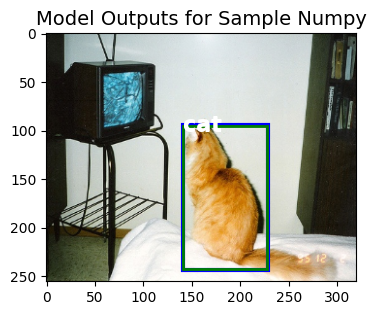

In [14]:
img_to_plot = img_model[0].cpu().detach().numpy()
img_to_plot = (img_to_plot + 128).astype(np.uint8)
img_to_plot = img_to_plot.transpose([1, 2, 0])

fig, axes = plt.subplots(1, 1, figsize=(4, 4))
axes.imshow(img_to_plot)

subplot_title=("Model Outputs for Sample Numpy")
axes.set_title(subplot_title, fontsize = 14)

# Predicted boxes & labels:
boxes_resized = [[box[0] * img_to_plot.shape[1], \
                  box[1] * img_to_plot.shape[0], \
                  box[2] * img_to_plot.shape[1], \
                  box[3] * img_to_plot.shape[0]] for box in all_images_boxes[0].detach().cpu().numpy()]
detected_labels = all_images_labels[0]
for b in range(len(boxes_resized)):
    if(detected_labels[b] != 0):
        bb = boxes_resized[b]
        rect = patches.Rectangle((bb[0], bb[1]), bb[2] - bb[0], bb[3] - bb[1], linewidth=3,
                                edgecolor='b', facecolor="none")
        lbl_string = test_set.voc_id_to_label_map[detected_labels[b].cpu().detach().item()]
        axes.text(bb[0], (bb[1]), lbl_string, verticalalignment='center', color='white', fontsize=16, weight='bold')
        axes.add_patch(rect)

nms_in_hw_available = True
if nms_in_hw_available:
    # [Optional] Hardware NMS boxes & labels:
    # modify below hardcoded boxes and classes if needed
    hardware_boxes = [[0.44, 0.37, 0.71, 0.95]]
    hardware_labels = [8]

    boxes_resized = [[box[0] * img_to_plot.shape[1], \
                    box[1] * img_to_plot.shape[0], \
                    box[2] * img_to_plot.shape[1], \
                    box[3] * img_to_plot.shape[0]] for box in hardware_boxes]
    detected_labels = hardware_labels
    for b in range(len(boxes_resized)):
        if(detected_labels[b] != 0):
            bb = boxes_resized[b]
            rect = patches.Rectangle((bb[0], bb[1]), bb[2] - bb[0], bb[3] - bb[1], linewidth=2,
                                    edgecolor='g', facecolor="none")
            lbl_string = test_set.voc_id_to_label_map[detected_labels[b]]
            axes.text(bb[0], (bb[1]), lbl_string, verticalalignment='center', color='white', fontsize=16, weight='bold')
            axes.add_patch(rect)

plt.show()